# Natural Language Processing, specifically topic modeling with Latent Dirichlet Allocation.

In [1]:
from __future__ import division

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.sql import text

In [3]:
%matplotlib inline  

In [4]:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk")

# Retrieve df from db . . .

Query the reddit table in the insight database.

In [5]:
eng = create_engine('postgresql:///insight')
with eng.connect() as con:            
    rs = con.execute(text('SELECT * FROM reddit'))            
    data = np.array(rs.fetchall())[:, 1:] # drop "Id" column from database table.

In [6]:
df = pd.DataFrame({
    'Day': data[:, 0].astype(np.float), 
    'Body': data[:, 1],
    'Author': data[:, 2],
    'Score': data[:, 3].astype(np.int),
    'Clean_body': data[:, 4],
    'Body_length': data[:, 5].astype(np.int)})

In [7]:
N = df.shape[0]
M = df.shape[1]

In [8]:
print N, M

2680 6


# . . . or from csv file.

In [5]:
df = pd.read_csv('data_post_processing.csv')

In [6]:
N = df.shape[0]
M = df.shape[1]

In [7]:
print N, M

2686 7


In [9]:
df.index

RangeIndex(start=0, stop=2686, step=1)

# Pre-processing required for topic modeling with Gensim's LDA package.

This section borrows many bits of code from Jordan Barber: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

In [9]:
import re
import nltk

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from stop_words import get_stop_words
english_stop_words = get_stop_words('en')

from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

import gensim
from gensim import corpora, models

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [10]:
docs = df.Clean_body.values

In [11]:
docs_p = []
for doc in docs:
    
    # Handle 
    doc = re.sub(r'number', '', doc)
    
    # Handle URLS
    doc = re.sub(r'httpaddr', '', doc)
    
    # Handle Email Addresses
    doc = re.sub(r'emailaddr', '', doc)
    
    # Handle $ sign
    doc = re.sub(r'dollar', '', doc)
    
    # Handle long strings of vowels.
    doc = re.sub(r'[a|e|i|o|u]{3,}', '', doc)
    
    docs_p.append(doc)

In [12]:
tokens = []
for doc in docs_p:
    tokenized = tokenizer.tokenize(doc)
    tokens.append(tokenized)

In [13]:
stopped_tokens = []
for tokenized in tokens:
    stopped_tokenized = [token if len(token) > 2 else '' for token in tokenized 
                         if not token in english_stop_words]# and token not in extra_stop_tokens]
    stopped_tokenized = [token for token in stopped_tokenized if not token in ['']]
    stopped_tokens.append(stopped_tokenized)

In [14]:
docs_pp = []

for row in stopped_tokens:
    doc_recon = ''
    for token in row:
        doc_recon += token + ' '
    docs_pp.append(doc_recon)

In [15]:
stemmed_stopped_tokens = []
for stopped_tokenized in stopped_tokens:
    stemmed_stopped_tokenized = [p_stemmer.stem(token) for token in stopped_tokenized]
    stemmed_stopped_tokens.append(stemmed_stopped_tokenized)

In [16]:
text = []

for stemmed_stopped_tokenized in stemmed_stopped_tokens:
    for token in stemmed_stopped_tokenized:
        text.append(token)

In [17]:
fd = nltk.FreqDist(text)

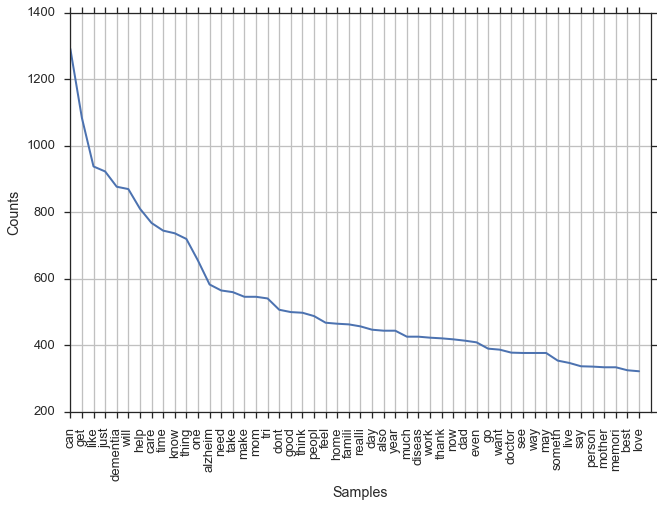

In [18]:
fd.plot(50, cumulative=False)

How many terms are there in the corpus at this point?

In [19]:
print len(fd)

6947


Remove words from corpus that are too short, too long, too infrequent, or too frequent.

In [37]:
corpus_specific_stop_words = []

for key, value in fd.iteritems():
    if len(key) < 4 or len(key) > 10 or value < 4 or value > 900:
        corpus_specific_stop_words.append(key)

In [38]:
cleaned_tokens = []

for tokens in stemmed_stopped_tokens:
    cleaned_tokens.append([token for token in tokens if token not in corpus_specific_stop_words])

Create dictionary and corpus.

In [40]:
dictionary = corpora.Dictionary(cleaned_tokens) # dictionary.token2id[<str>] gives the integer value corresponding to the token 'str'

In [41]:
len(dictionary)

2191

In [42]:
corpus = [dictionary.doc2bow(tokens) for tokens in cleaned_tokens]

Remove words with too low or too high TF-IDF?

In [43]:
tfidf = gensim.models.tfidfmodel.TfidfModel(corpus, id2word=dictionary)

In [44]:
low_tfidf_keys = []

for doc in corpus:
    for key, value in tfidf[doc]:
        if value < 0.05:
            low_tfidf_keys.append(dictionary[key])
            
low_tfidf_keys = np.unique(low_tfidf_keys)

In [45]:
low_tfidf_keys

array([u'also', u'alway', u'alzheim', u'anoth', u'best', u'call', u'cant',
       u'care', u'caus', u'come', u'dementia', u'diagnos', u'differ',
       u'diseas', u'doctor', u'doesnt', u'dont', u'even', u'famili',
       u'feel', u'find', u'first', u'give', u'good', u'hard', u'help',
       u'home', u'hope', u'isnt', u'keep', u'know', u'littl', u'live',
       u'long', u'look', u'love', u'luck', u'make', u'mani', u'memori',
       u'might', u'much', u'need', u'never', u'patient', u'peopl',
       u'person', u'realli', u'seem', u'someon', u'someth', u'start',
       u'still', u'sure', u'take', u'talk', u'tell', u'thank', u'that',
       u'thing', u'think', u'time', u'understand', u'want', u'well',
       u'will', u'wish', u'work', u'year', u'your'], 
      dtype='<U10')

In [46]:
high_tfidf_keys = []

for doc in corpus:
    for key, value in tfidf[doc]:
        if value > 0.95:
            high_tfidf_keys.append(dictionary[key])
            
high_tfidf_keys = np.unique(high_tfidf_keys)

In [47]:
high_tfidf_keys

array([u'along', u'also', u'easier', u'funni', u'good', u'hard', u'idea',
       u'prescript', u'read', u'seen', u'sorri', u'studi', u'water',
       u'well'], 
      dtype='<U9')

In [48]:
cleaned_tokens_p = []

for tokens in cleaned_tokens:
    cleaned_tokens_p.append([token for token in tokens 
                             if token not in low_tfidf_keys and token not in high_tfidf_keys])

In [50]:
dictionary = corpora.Dictionary(cleaned_tokens_p) # dictionary.token2id[<str>] gives the integer value corresponding to the token 'str'

In [51]:
len(dictionary)

2111

In [54]:
corpus = [dictionary.doc2bow(tokens) for tokens in cleaned_tokens_p]

# Topic discovery using Gensim's LDA package.

In [81]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary, chunksize=len(corpus), passes=80)

In [57]:
for item in ldamodel.print_topics(num_topics=ldamodel.num_topics, num_words=10):
    print item
    print ''

(0, u'0.012*test + 0.011*brain + 0.009*earli + 0.008*symptom + 0.007*drug + 0.006*research + 0.006*onset + 0.006*cognit + 0.006*gener + 0.006*medic')

(1, u'0.011*mother + 0.008*rememb + 0.007*right + 0.006*life + 0.006*father + 0.006*situat + 0.006*back + 0.005*sometim + 0.005*better + 0.005*away')

(2, u'0.013*support + 0.009*caregiv + 0.007*group + 0.007*medic + 0.007*check + 0.007*nurs + 0.007*servic + 0.006*area + 0.006*social + 0.006*state')



Run the beautiful LDA visualization from pyLDAvis.

In [58]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      55.525660        1       1  0.069639  0.135291
0      24.100913        1       2 -0.170553 -0.015587
2      20.373427        1       3  0.100914 -0.119705, topic_info=     Category        Freq      Term       Total  loglift  logprob
term                                                             
501   Default  146.000000      test  146.000000  30.0000  30.0000
463   Default  172.000000   support  172.000000  29.0000  29.0000
679   Default  142.000000     brain  142.000000  28.0000  28.0000
382   Default  322.000000    mother  322.000000  27.0000  27.0000
875   Default  215.000000   caregiv  215.000000  26.0000  26.0000
1897  Default   90.000000      drug   90.000000  25.0000  25.0000
206   Default  111.000000   symptom  111.000000  24.0000  24.0000
1463  Default  160.000000     earli  160.000000  23.0000  23.0000
348   Default   69.000000    servic   69.000000  22.0000  22.0000
1347  Default   76.000000     onset   76.000000  21.0000  21.0000
685   Default   80.000000     group   80.000000  20.0000  20.0000
1601  Default   75.000000    cognit   75.000000  19.0000  19.0000
1016  Default  156.000000      nurs  156.000000  18.0000  18.0000
2093  Default  227.000000    rememb  227.000000  17.0000  17.0000
367   Default   80.000000    social   80.000000  16.0000  16.0000
1271  Default  109.000000  research  109.000000  15.0000  15.0000
496   Default  140.000000     check  140.000000  14.0000  14.0000
579   Default   87.000000     gener   87.000000  13.0000  13.0000
1844  Default   59.000000     local   59.000000  12.0000  12.0000
1018  Default   79.000000      area   79.000000  11.0000  11.0000
1206  Default   62.000000   resourc   62.000000  10.0000  10.0000
209   Default   72.000000    provid   72.000000   9.0000   9.0000
290   Default   65.000000    result   65.000000   8.0000   8.0000
1334  Default   54.000000  attorney   54.000000   7.0000   7.0000
473   Default   67.000000     offer   67.000000   6.0000   6.0000
1085  Default   61.000000    articl   61.000000   5.0000   5.0000
1961  Default   79.000000    effect   79.000000   4.0000   4.0000
729   Default   94.000000     state   94.000000   3.0000   3.0000
920   Default  193.000000     medic  193.000000   2.0000   2.0000
1211  Default   71.000000    associ   71.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
685    Topic3   71.932746     group   80.427409   1.4793  -4.9778
618    Topic3   22.257811    afford   23.928834   1.5185  -6.1508
570    Topic3   30.452809      cost   33.500967   1.4955  -5.8373
463    Topic3  140.085455   support  172.454278   1.3831  -4.3113
993    Topic3   47.663945     power   54.596160   1.4552  -5.3893
209    Topic3   61.999869    provid   72.736284   1.4312  -5.1264
1086   Topic3   36.303389   program   41.156486   1.4655  -5.6616
1018   Topic3   64.734430      area   79.444073   1.3862  -5.0832
473    Topic3   55.663500     offer   67.067045   1.4046  -5.2342
367    Topic3   63.739715    social   80.499214   1.3575  -5.0987
1211   Topic3   56.092789    associ   71.777059   1.3444  -5.2265
1859   Topic3   29.835900     organ   35.412134   1.4196  -5.8578
82     Topic3   45.210417     adult   61.340815   1.2858  -5.4422
729    Topic3   62.016481     state   94.926569   1.1652  -5.1261
875    Topic3   92.481265   caregiv  215.175102   0.7465  -4.7265
496    Topic3   70.478320     check  140.779300   0.8991  -4.9982
931    Topic3   54.314238    assist   99.800698   0.9825  -5.2587
1016   Topic3   70.135051      nurs  156.561209   0.7879  -5.0031
1318   Topic3   46.556641    option   79.640026   1.0541  -5.4128
920    Topic3   70.687811     medic  193.640886   0.5832  -4.9952
671    Topic3   46.104063    inform   93.846802   0.8802  -5.4226
745    Topic3   53.341504     place  134.464056   0.6664  -5.2768
1565   Topic3   40.856669      link   79.424435   0.9262 

My choice of labels for the 3 topics:  0. Research Discussion, 1. Emotional Support, 2. Problem Solving.

In [58]:
print df.Body.values[3]
print ldamodel.get_document_topics(corpus[3])

Sounds tough.  I'm a speech pathologist and  I see people with FTD in my practice. In my experience, your mothers behavior is not uncommon. I wish I had some sage advice but I don't.   Do the best you can. I had a similar experience with my grandmother who had huntingtons dz. I was the only one to care for her.  Much of what I have left memory wise is how i dealt with her, both the good and the regrets...
[(0, 0.021444203786249678), (1, 0.95693467624684148), (2, 0.021621119966909019)]


In [62]:
print df.Body.values[2400]
print ldamodel.get_document_topics(corpus[2400])

I know someone mentioned this below but I just want to make sure you follow through with the Social Security/Disability route. I had no idea that was an option, but Alzheimer's is a disease they rush through the process because it is an incurable thing and they call it something like a "compassionate allowance." Our family has no financial problems to begin with and we get something like $1000 or $1100 a month just from that to use toward caregivers. It obviously doesn't cover anything near the whole amount that you need but it definitely helps.
[(0, 0.016408280525601896), (1, 0.016831196988790455), (2, 0.96676052248560762)]


In [63]:
print df.Body.values[1500]
print ldamodel.get_document_topics(corpus[1500])

What sort of scan? MRIs are [not very accurate]( http://www.ncbi.nlm.nih.gov/pubmed/20683185) for the subtle changes.

&gt;As magnetic resonance imaging (MRI) has a relatively low sensitivity for bvFTD, a substantial proportion of patients may present with a normal MRI. 


[(0, 0.94520214063427122), (1, 0.027394629846297883), (2, 0.027403229519430902)]


Project all documents into the 3-topic space.

In [73]:
topic_vectors = [ldamodel.get_document_topics(doc) for doc in corpus]

In [74]:
doc_topic_proj = np.zeros((len(topic_vectors), 3))

for i, vec in enumerate(topic_vectors):
    for (topic, frac) in vec:
        doc_topic_proj[i][topic] = frac

In [75]:
doc_topic_proj[:10]

array([[ 0.07438747,  0.07678212,  0.84883041],
       [ 0.08630051,  0.82679849,  0.08690101],
       [ 0.7529743 ,  0.13414478,  0.11288091],
       [ 0.02144473,  0.95693738,  0.02161789],
       [ 0.0556873 ,  0.88770617,  0.05660652],
       [ 0.06699301,  0.07199224,  0.86101475],
       [ 0.64485484,  0.05275943,  0.30238573],
       [ 0.46615675,  0.47920272,  0.05464054],
       [ 0.35155873,  0.63697334,  0.01146793],
       [ 0.09328295,  0.08729318,  0.81942387]])

Most frequecies sum to 1.  Not all, though.  Not sure why.  This is something that I chose not to explore given the time constraints of the project.

In [76]:
np.sum(np.sum(doc_topic_proj, axis=1) < 0.98)

0

To plot docs on a 2D triangle (simplex), assign topic 0 to the bottom lhs vertex, topic 1 to the top vertex, and topic 2 to the bottom rhs vertex.

In [78]:
symplex_bottom_unit_vec = np.array([1, 0])
symplex_lhs_unit_vec = np.array([np.cos(np.pi / 3), np.sin(np.pi / 3)])

In [79]:
doc_symplex_coord = symplex_bottom_unit_vec.reshape(-1, 1).dot(doc_topic_proj.T[2].reshape(1, -1)).T + \
                    symplex_lhs_unit_vec.reshape(-1, 1).dot(doc_topic_proj.T[1].reshape(1, -1)).T

In [80]:
doc_symplex_coord

array([[ 0.88722147,  0.06649527],
       [ 0.50030025,  0.71602849],
       [ 0.1799533 ,  0.11617279],
       ..., 
       [ 0.58007863,  0.52128552],
       [ 0.50167849,  0.54080275],
       [ 0.8690136 ,  0.07872938]])

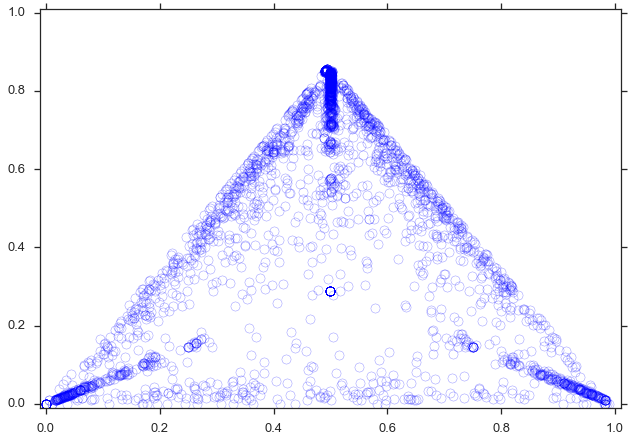

In [82]:
plt.figure()
plt.plot(doc_symplex_coord.T[0], doc_symplex_coord.T[1], ls='none', marker='o', mfc='none', mec='b', mew=0.2, alpha=1.)
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01);

In [89]:
orig_text_of_post = np.array([[str(i), str(post.encode('utf-8'))] for i, post in enumerate(df.Body.values)])

In [89]:
np.savetxt('coords_and_text.csv', np.hstack((doc_symplex_coord, doc_topic_proj, orig_text_of_post)), fmt='%.4f', delimiter=",")